In [1]:
#|default_exp sgd

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import deepcopy
from contextlib import contextmanager
from datasets import load_dataset,load_dataset_builder

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from torch.optim import lr_scheduler

from minai.datasets import *
from minai.conv import *
from minai.learner import *
from minai.activations import *
from minai.init import *

/home/studio-lab-user/.conda/envs/fastai/lib/python3.9/site-packages/deeplake/util/check_latest_version.py:32: UserWarning: A newer version of deeplake (3.9.5) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


In [3]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

import logging
logging.disable(logging.WARNING)

set_seed(42)

In [4]:
x1, y1 = 'image', 'label'
name = 'anubhavmaity/notMNIST'
dsd = load_dataset(name)

x_mean, x_std = tensor(0.43), tensor(0.46)

@inplace
def transformi(b): b[x1] = [(TF.to_tensor(o)  - x_mean)/x_std for o in b[x1]]

bs = 128
tds = dsd.with_transform(transformi)

dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([128, 1, 28, 28]), tensor([6, 9, 4, 8, 4, 0, 3, 3, 5, 2]))

In [5]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
act_gr = partial(GeneralRelu, leak=0.1, sub=0.5)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

## SGD

In [6]:
class SGD:
    def __init__(self, params, lr, wd=1e-6):
        params = list(params)
        fc.store_attr()
        self.i = 0
    
    def step(self):
        with torch.no_grad():
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i += 1
    
    def opt_step(self, p): p -= p.grad * self.lr
    
    def reg_step(self, p):
        if self.wd != 0: p  *= 1 - self.lr * self.wd
    
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [7]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=0.4, cbs=cbs, opt_func=SGD)

accuracy,loss,epoch,train
0.860,0.484,0,True
0.908,0.308,0,False
0.927,0.259,1,True
0.922,0.265,1,False
0.942,0.201,2,True
0.924,0.262,2,False


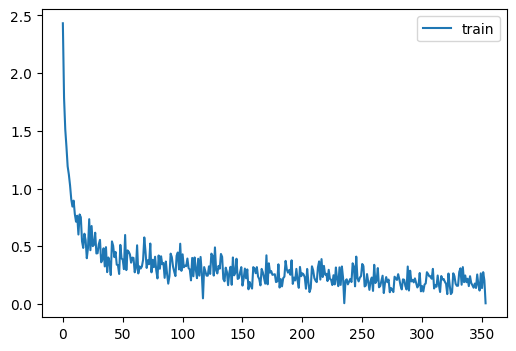

In [8]:
learn.fit(3)

Consider the difference between weight decay and L2 regularization:


    weight -= lr*wd*weight
    
    
    ...vs...
    

    weight.grad += wd*weight

For the first one the order of applying `opt_step` & `reg_step` does not matter. For the second one the `reg_step` has to be applied first.

## Momentum

In [9]:
xs = torch.linspace(-4, 4, 100)
ys = 1 - (xs/3) ** 2 + torch.randn(100) * 0.1

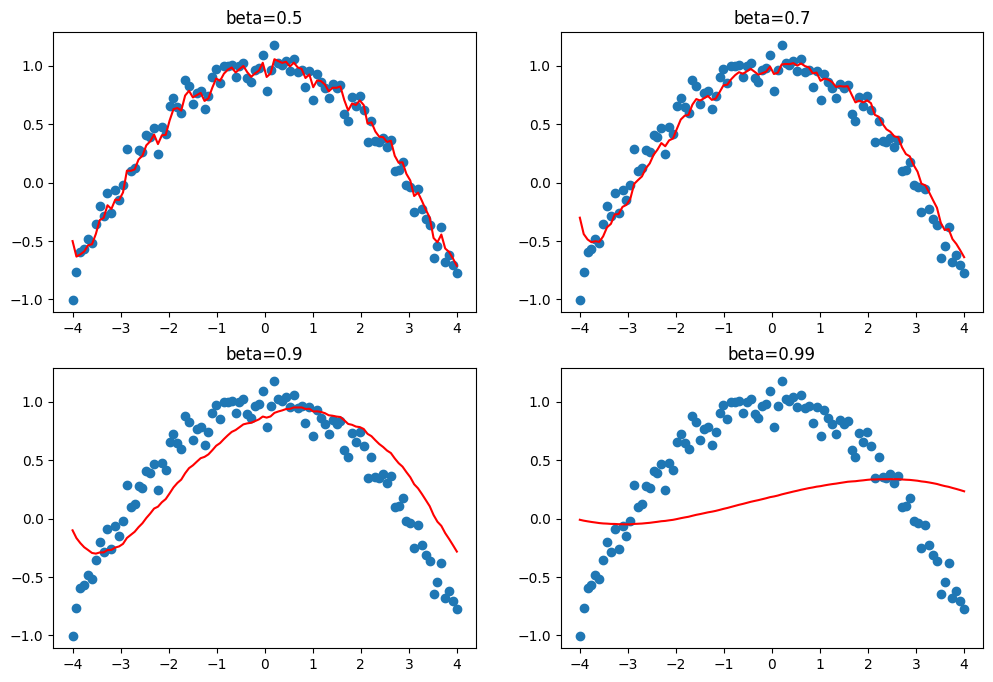

In [10]:
_, axs = plt.subplots(2, 2, figsize=(12,8))
betas = [0.5, 0.7, 0.9, 0.99]
for beta, ax in zip(betas, axs.flatten()):
    ax.scatter(xs, ys)
    avg, res = 0, []
    for yi in ys:
        avg = beta*avg + (1-beta)*yi # avg.lerp_(yi, 1-beta)
        res.append(avg)
    ax.plot(xs, np.array(res), color='red')
    ax.set_title(f'beta={beta}')

In [11]:
class Momentum(SGD):
    def __init__(self, params, lr, wd=0, mom=0.9):
        super().__init__(params, lr=lr, wd=wd)
        self.mom = mom
    
    def opt_step(self, p):
        if not hasattr(p, 'grad_avg'): p.grad_avg = torch.zeros_like(p.grad)
        p.grad_avg = p.grad_avg * self.mom + p.grad * (1 - self.mom)
        p -= self.lr * p.grad_avg

In [12]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=1.5, cbs=cbs, opt_func=Momentum)

accuracy,loss,epoch,train
0.862,0.474,0,True
0.916,0.284,0,False
0.927,0.248,1,True
0.924,0.253,1,False
0.945,0.191,2,True
0.927,0.249,2,False


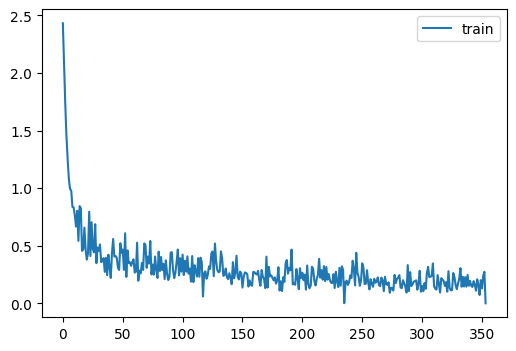

In [13]:
learn.fit(3)

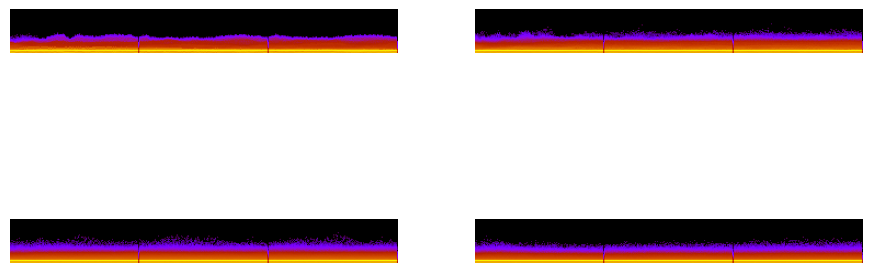

In [14]:
astats.color_dim()

## RMSProp

In [15]:
class RMSProp(SGD):
    def __init__(self, params, lr, wd=0., sqr_mom=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.sqr_mom, self.eps = sqr_mom, eps
    
    def opt_step(self, p):
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = p.grad ** 2
        p.sqr_avg = p.sqr_avg * self.sqr_mom + p.grad**2*(1 - self.sqr_mom)
        upd = p.grad / (p.sqr_avg.sqrt() + self.eps)
        p -= self.lr * upd

accuracy,loss,epoch,train
0.851,0.511,0,True
0.807,0.602,0,False
0.924,0.264,1,True
0.919,0.274,1,False
0.940,0.202,2,True
0.920,0.271,2,False


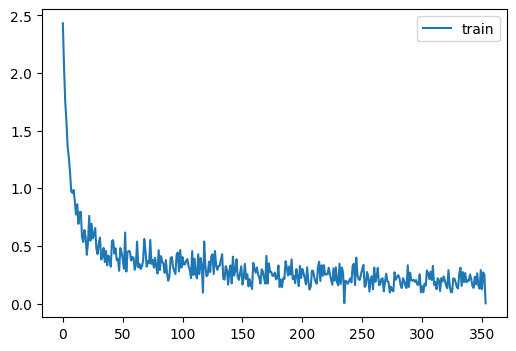

In [16]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-3, cbs=cbs, opt_func=RMSProp)
learn.fit(3)

## Adam 
> RMSProp + Momentum

In [17]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
    
    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1 - self.beta2)*(p.grad ** 2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

accuracy,loss,epoch,train
0.866,0.462,0,True
0.916,0.293,0,False
0.915,0.293,1,True
0.927,0.259,1,False
0.929,0.250,2,True
0.929,0.279,2,False


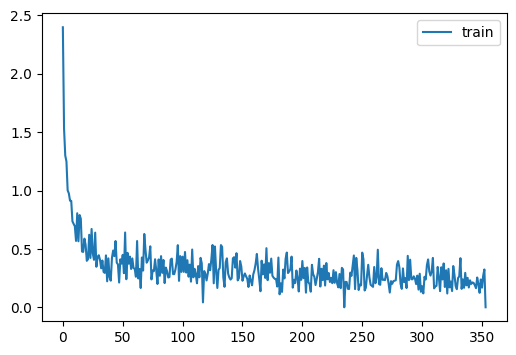

In [18]:
set_seed(2)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=3e-2, cbs=cbs, opt_func=Adam)
learn.fit(3)

## Schedulers

We have already seen how we can easily write a custom LR-adjusting callback or `Learner`, or can use the predefined PyTorch schedulers. We will use predefined ones for now since there is nothing new to learn in implementing them ourselves.

In [19]:
dir(lr_scheduler)

['ChainedScheduler',
 'ConstantLR',
 'CosineAnnealingLR',
 'CosineAnnealingWarmRestarts',
 'Counter',
 'CyclicLR',
 'EPOCH_DEPRECATION_WARNING',
 'ExponentialLR',
 'LambdaLR',
 'LinearLR',
 'MultiStepLR',
 'MultiplicativeLR',
 'OneCycleLR',
 'Optimizer',
 'ReduceLROnPlateau',
 'SequentialLR',
 'StepLR',
 '_LRScheduler',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'bisect_right',
 'inf',
 'math',
 'types',
 'warnings',
 'weakref',
 'wraps']

In [20]:
' '.join(o for o in dir(lr_scheduler) if o[0].isupper() and o[1].islower())

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR'

In [21]:
from fastcore.basics import Self as X

In [22]:
' '.join(filter(X[0].isupper() and X[1].islower(), dir(lr_scheduler)))

'ChainedScheduler ConstantLR CosineAnnealingLR CosineAnnealingWarmRestarts Counter CyclicLR ExponentialLR LambdaLR LinearLR MultiStepLR MultiplicativeLR OneCycleLR Optimizer ReduceLROnPlateau SequentialLR StepLR bisect_right inf math types warnings weakref wraps'

In [23]:
learn = TrainLearner(get_model(), dls, F.cross_entropy, lr=6e-3, cbs=[DeviceCB(), SingleBatchCB()])
learn.fit(1)

In [24]:
opt = learn.opt
' '.join(o for o in dir(opt) if o[0] != '_')

'add_param_group defaults load_state_dict param_groups state state_dict step zero_grad'

In [25]:
opt

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 0.006
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [26]:
param = next(iter(learn.model.parameters()))
st = opt.state[param]

In [27]:
len(opt.param_groups)

1

In [28]:
st

{'momentum_buffer': None}

In [29]:
pg = opt.param_groups[0]; list(pg)

['params',
 'lr',
 'momentum',
 'dampening',
 'weight_decay',
 'nesterov',
 'maximize',
 'foreach']

In [30]:
sched = lr_scheduler.CosineAnnealingLR(opt, 100)

In [31]:
sched.base_lrs

[0.006]

In [32]:
sched.get_last_lr()

[0.006]

In [33]:
def sched_lrs(sched, steps):
    lrs = [sched.get_last_lr()]
    for i in range(steps):
        sched.optimizer.step()
        sched.step()
        lrs.append(sched.get_last_lr())
    plt.plot(lrs)

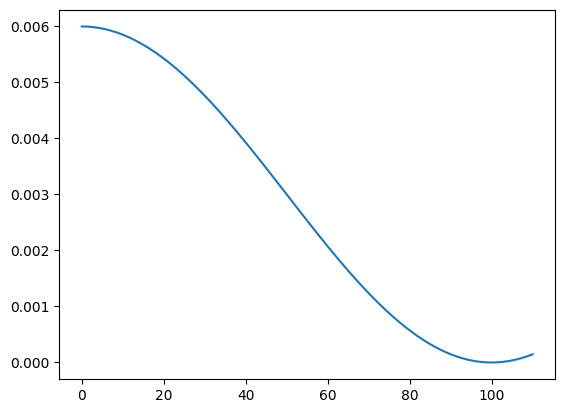

In [34]:
sched_lrs(sched, 110)

## Scheduler Callbacks

In [35]:
#|export
class BaseSchedCB(Callback):
    def __init__(self, sched): self.sched = sched
    def before_fit(self, learn): self.schedo = self.sched(learn.opt)
    def _step(self, learn):
        if learn.training: self.schedo.step()

In [36]:
#|export
class BatchSchedCB(BaseSchedCB):
    def after_batch(self, learn): self._step(learn)

In [37]:
#|export
class HasLearnCB(Callback):
    def before_fit(self, learn): self.learn = learn
    def after_fit(self, learn): self.learn = None

In [38]:
#|export
class RecorderCB(Callback):
    def __init__(self, **d): self.d = d
    def before_fit(self, learn):
        self.recs = {k: [] for k in self.d}
        self.pg = learn.opt.param_groups[0]
    
    def after_batch(self, learn):
        if not learn.training: return
        for k,v in self.d.items():
            self.recs[k].append(v(self))
    
    def plot(self):
        for k, v in self.recs.items():
            plt.plot(v, label=k)
            plt.legend()
            plt.show()

In [39]:
def _lr(cb): return cb.pg['lr']

In [40]:
len(dls.train)

118

In [41]:
tmax = 3 * len(dls.train)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=tmax)

accuracy,loss,epoch,train
0.871,0.439,0,True
0.916,0.285,0,False
0.931,0.237,1,True
0.936,0.223,1,False
0.957,0.151,2,True
0.939,0.208,2,False


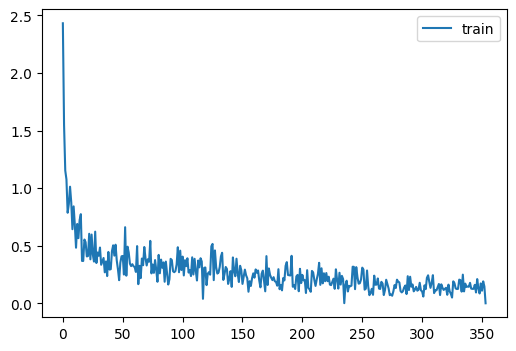

In [42]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
rec = RecorderCB(lr=_lr)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

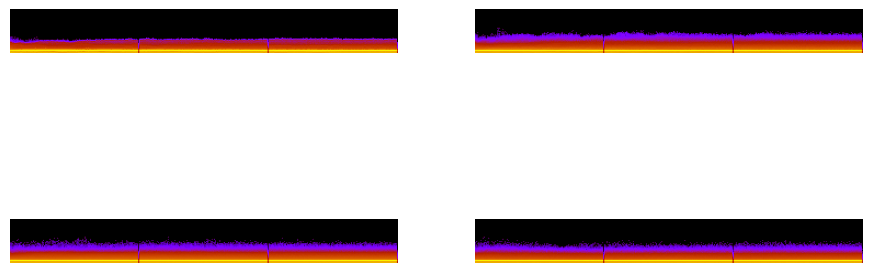

In [43]:
astats.color_dim()

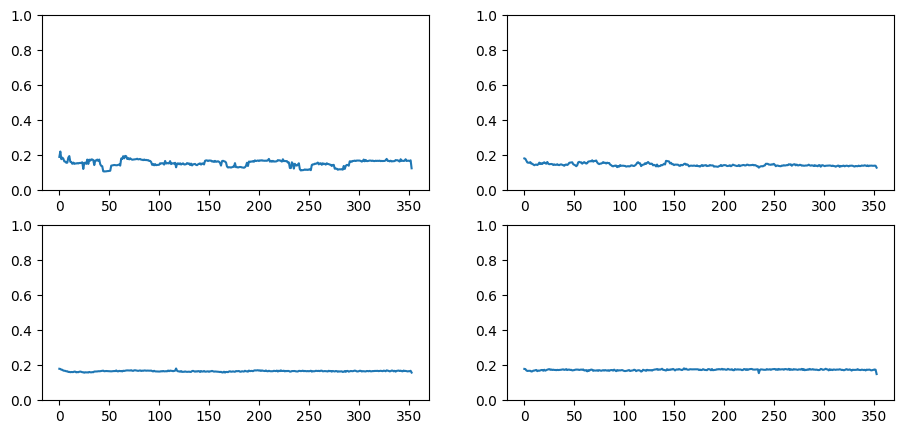

In [44]:
astats.dead_chart()

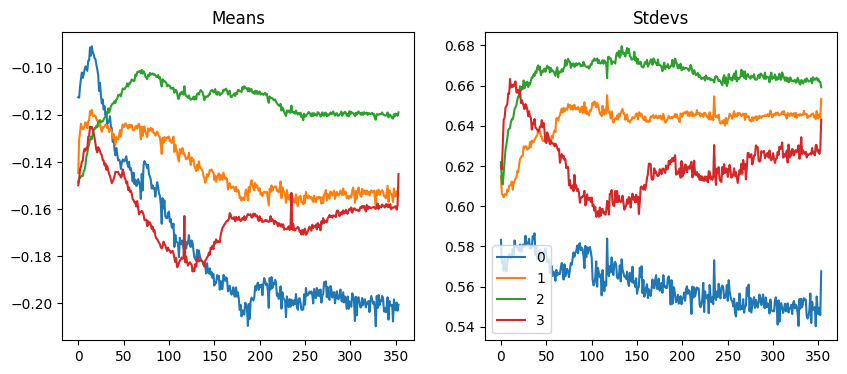

In [45]:
astats.plot_stats()

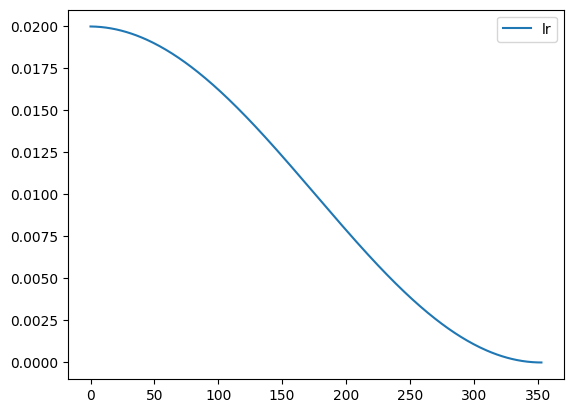

In [46]:
rec.plot()

In [47]:
#|export
class EpochSchedCB(BaseSchedCB):
    def after_epoch(self, learn): self._step(learn)

accuracy,loss,epoch,train
0.870,0.443,0,True
0.900,0.329,0,False
0.926,0.255,1,True
0.921,0.278,1,False
0.953,0.159,2,True
0.936,0.215,2,False


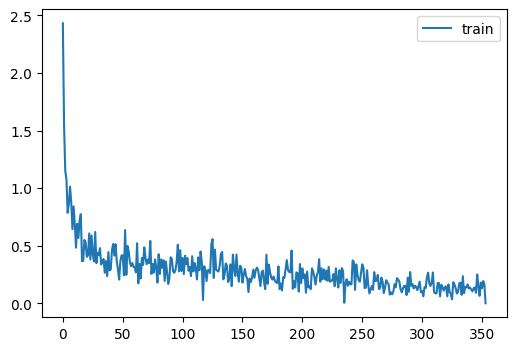

In [48]:
set_seed(42)
sched = partial(lr_scheduler.CosineAnnealingLR, T_max=3)
xtra = [EpochSchedCB(sched), rec]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=2e-2, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(3)

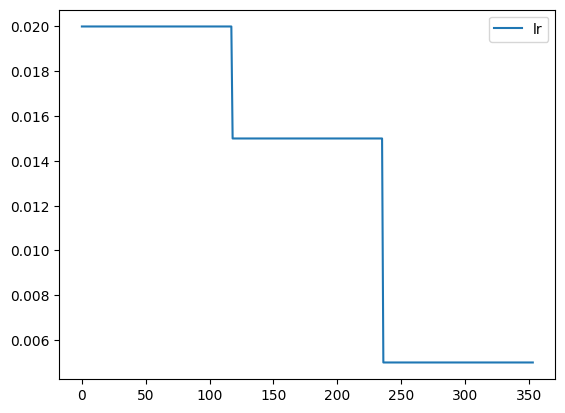

In [49]:
rec.plot()

## 1cycle training

In [50]:
def _beta1(cb): return cb.pg['betas'][0]
rec = RecorderCB(lr=_lr, mom=_beta1)

accuracy,loss,epoch,train
0.828,0.580,0,True
0.832,0.661,0,False
0.895,0.388,1,True
0.875,0.394,1,False
0.925,0.271,2,True
0.925,0.270,2,False
0.946,0.182,3,True
0.937,0.219,3,False
0.969,0.107,4,True
0.942,0.206,4,False


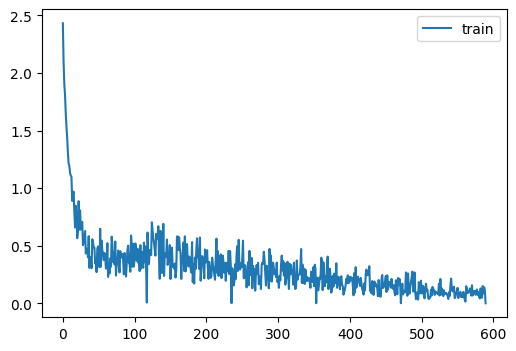

In [51]:
set_seed(42)
lr,epochs=6e-2,5
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), rec]
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

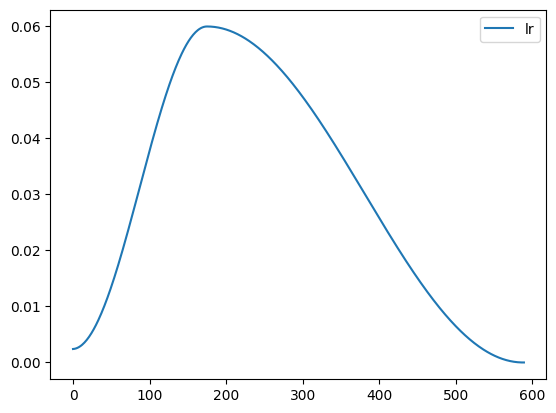

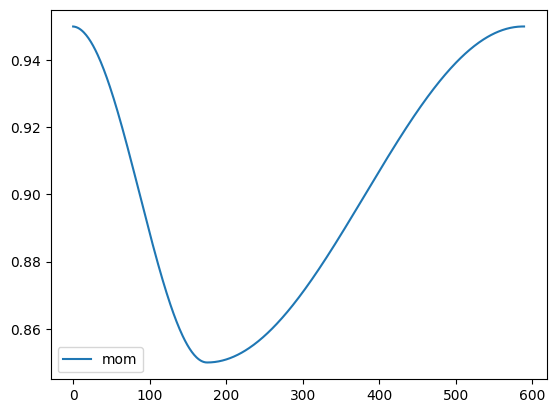

In [52]:
rec.plot()

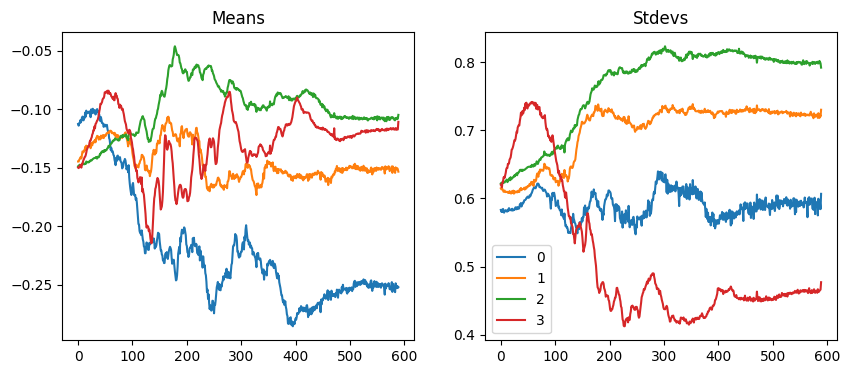

In [53]:
astats.plot_stats()

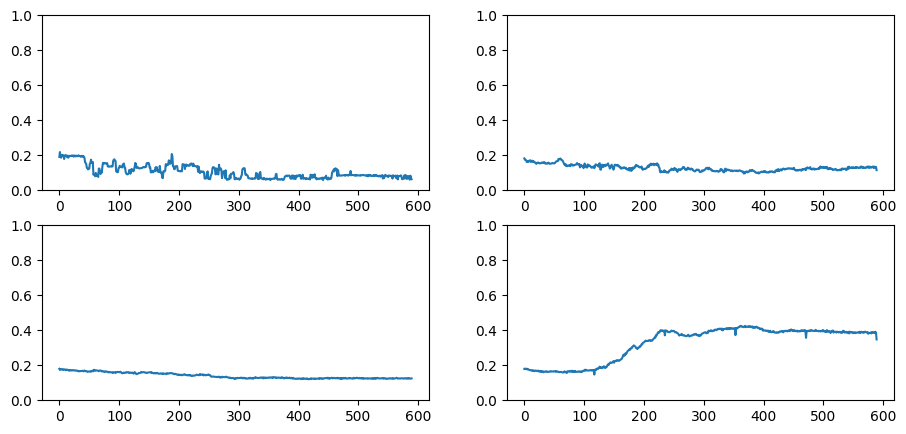

In [54]:
astats.dead_chart()

## Export

In [55]:
import nbdev; nbdev.nbdev_export()